In [1]:
import sys
sys.path.append("..")  # to make utils importable
import utils.data_loader
import numpy
import bs4
import utils.consts
import networkx

In [2]:
dataset = utils.data_loader.load_dataset()


def parse_html(html_row: str) -> str:
    return bs4.BeautifulSoup(html_row, "html.parser").get_text(separator=" ")


dataset["Body"] = dataset["Body"].apply(parse_html)
dataset = dataset[utils.consts.COLS_TO_KEEP + ["ParentId"]]

Data loaded


In [32]:
graph = networkx.Graph()

users = dataset.OwnerUserId.dropna().unique()
questions = dataset[dataset.PostTypeId == 1]
answers = dataset[dataset.PostTypeId == 2]

# tags
user_to_tags = {user : set() for user in users}
question_to_tags = {}
for i in range(len(questions)):
    question = questions.iloc[i]
    if question.Tags is not None:
        question_to_tags[question.Id] = set(question.Tags)

for i in range(len(answers)):
    answer = answers.iloc[i]
    if not numpy.isnan(answer.OwnerUserId) and answer.Tags is not None:
        user_to_tags[answer.OwnerUserId] |= set(answer.Tags)

# users
user_attributes = {}
for user in users:
    graph.add_node('u' + str(user))
    user_attributes[user] = {"type": "user", "tags": user_to_tags[user]}
networkx.set_node_attributes(graph, user_attributes)

# questions
question_attributes = {}
for i in range(len(questions)):
    question = questions.iloc[i]
    graph.add_node('q' + str(int(question.Id)))
    question_attributes[question.Id] = {"type": "question", "tags": question_to_tags[question.Id], "score": question.Score}
networkx.set_node_attributes(graph, question_attributes)

# min-max normalization
min_ = answers.Score.min()
max_ = answers.Score.max()

# user-question
for i in range(len(answers)):
    answer = answers.iloc[i]
    if answer.ParentId in questions.Id:
        graph.add_edge('u' + str(answer.OwnerUserId), 'q' + str(int(answer.ParentId)), weight=(answer.Score - min_) / (max_ - min_))

# user-user
for user1 in users:
    for user2 in users:
        if not numpy.isnan(user1) and not numpy.isnan(user2) and user1 < user2:
            user1_tags = user_to_tags[user1]
            user2_tags = user_to_tags[user2]
            if len(user1_tags | user2_tags) * len(user1_tags & user2_tags) == 0:
                continue
            w = (len(user1_tags & user2_tags) / len(user1_tags | user2_tags))
            if w >= 0.95:
                graph.add_edge('u' + str(user1), 'u' + str(user2), weight=w)

# # question-question
# for i in range(len(questions)):
#     for j in range(len(questions)):
#         if i < j:
#             question1 = questions.iloc[i].Id
#             question2 = questions.iloc[j].Id
#             question1_tags = question_to_tags[question1]
#             question2_tags = question_to_tags[question2]
#             if len(question1_tags | question2_tags) * len(question1_tags & question2_tags) == 0:
#                 continue
#             w = (len(question1_tags & question2_tags) / len(question1_tags | question2_tags))
#             if w >= 0.95:
#                 graph.add_edge('q' + str(int(question1)), 'q' + str(int(question2)), weight=w)

graph.remove_node("unan")

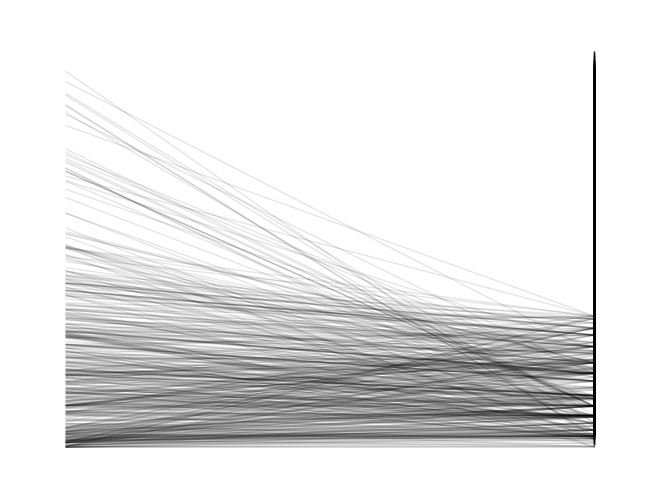

In [38]:
pos = {}
for i, user in enumerate(users):
    pos['u' + str(user)] = (0.2, 0.9 * i / len(users) + 0.05)

for i in range(len(questions)):
    question = questions.iloc[i]
    pos['q' + str(int(question.Id))] = (0.8, 0.9 * i / len(questions) + 0.05)

pos["unan"] = (0.4, 1.0)

networkx.draw(graph, pos, node_size=0, width=1, alpha=0.1)